In [2]:
'''
https://analyzeball.com/2020/06/20/playing-with-win-probability-models/
https://dberri.wordpress.com/2009/03/05/modeling-win-probability-for-a-college-basketball-game-a-guest-post-from-brian-burke/
https://medium.com/analytics-vidhya/a-simple-neural-network-for-in-game-win-probability-modeling-of-ncaa-basketball-games-58ab4e3ca0f9
'''

'\nhttps://analyzeball.com/2020/06/20/playing-with-win-probability-models/\nhttps://dberri.wordpress.com/2009/03/05/modeling-win-probability-for-a-college-basketball-game-a-guest-post-from-brian-burke/\nhttps://medium.com/analytics-vidhya/a-simple-neural-network-for-in-game-win-probability-modeling-of-ncaa-basketball-games-58ab4e3ca0f9\n'

In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv('../Data/pbp_modelling_data.csv')

In [4]:
test_games = df['GAME_ID'].unique()[-500:]
test_games = np.append(test_games, 21501228)

In [5]:
test = df[df['GAME_ID'].isin(test_games)]
train = df[~(df['GAME_ID'].isin(test_games))]

In [6]:
train = train.drop('GAME_ID', axis = 1).set_index('time_remaining')
test = test.set_index(['time_remaining', 'GAME_ID'])

In [7]:
from sklearn.linear_model import LogisticRegression

In [8]:
X = train.drop('home_team_win', axis = 1)
y = train['home_team_win']

In [9]:
X.head()

,home_poss,diff,OT_ind
time_remaining,,,
2880,0.0,0.0,0.0
2880,1.0,0.0,0.0
2877,1.0,0.0,0.0
2874,1.0,0.0,0.0
2871,1.0,0.0,0.0


In [10]:
models = {}
for time in X.index.unique():
    model_temp = LogisticRegression()
    X_temp = X.loc[time]
    y_temp = y.loc[time]
    model_temp.fit(X_temp.values, y_temp.values)
    models[time] = model_temp

In [24]:
X_temp

,home_poss,diff,OT_ind
time_remaining,,,
0,0.0,-12.0,0.0
0,0.0,2.0,0.0
0,0.0,16.0,0.0
0,1.0,-1.0,0.0
0,1.0,-1.0,0.0
...,...,...,...
0,0.0,-6.0,0.0
0,0.0,20.0,0.0
0,0.0,-26.0,0.0


In [11]:
test = test.sort_index()

In [13]:
import warnings
warnings.filterwarnings('ignore')
probs = []
preds = []
for time in test.index.levels[0]:
    temp = test.loc[time].drop('home_team_win', axis = 1)
    probs.append(pd.DataFrame(models[time].predict_proba(temp), columns = ['prob_home_lose', 'prob_home_win']))
    preds.append(pd.DataFrame(models[time].predict(temp), columns=['preds']))

probs_df = pd.concat(probs).reset_index(drop=True)
preds_df = pd.concat(preds).reset_index(drop=True)

test_df = pd.concat([test.reset_index(), probs_df, preds_df], axis = 1).set_index('GAME_ID').sort_index().sort_values(by=['OT_ind','time_remaining'], ascending=[True, False])

test_df['time'] = 2880-test_df['time_remaining']

test_df

,time_remaining,home_poss,diff,OT_ind,home_team_win,prob_home_lose,prob_home_win,preds,time
GAME_ID,,,,,,,,,
21501228,2880,0.0,0.0,0.0,1.0,0.423515,0.576485,1.0,0
21501228,2880,1.0,0.0,0.0,1.0,0.422919,0.577081,1.0,0
22000581,2880,0.0,0.0,0.0,1.0,0.423515,0.576485,1.0,0
22000581,2880,1.0,0.0,0.0,1.0,0.422919,0.577081,1.0,0
22000582,2880,0.0,0.0,0.0,0.0,0.423515,0.576485,1.0,0
...,...,...,...,...,...,...,...,...,...
22000874,3,0.0,5.0,2.0,1.0,0.003328,0.996672,1.0,2877
22000735,0,0.0,-5.0,2.0,0.0,0.999998,0.000002,0.0,2880
22000874,0,0.0,2.0,2.0,1.0,0.009322,0.990678,1.0,2880


In [14]:
t = test_df.where(test_df['OT_ind'] == 0).dropna()

In [15]:
t

,time_remaining,home_poss,diff,OT_ind,home_team_win,prob_home_lose,prob_home_win,preds,time
GAME_ID,,,,,,,,,
21501228,2880.0,0.0,0.0,0.0,1.0,0.423515,5.764848e-01,1.0,0.0
21501228,2880.0,1.0,0.0,0.0,1.0,0.422919,5.770807e-01,1.0,0.0
22000581,2880.0,0.0,0.0,0.0,1.0,0.423515,5.764848e-01,1.0,0.0
22000581,2880.0,1.0,0.0,0.0,1.0,0.422919,5.770807e-01,1.0,0.0
22000582,2880.0,0.0,0.0,0.0,0.0,0.423515,5.764848e-01,1.0,0.0
...,...,...,...,...,...,...,...,...,...
22001078,0.0,0.0,-2.0,0.0,0.0,0.993167,6.833398e-03,0.0,2880.0
22001078,0.0,1.0,-2.0,0.0,0.0,0.993629,6.370507e-03,0.0,2880.0
22001078,0.0,0.0,-2.0,0.0,0.0,0.993167,6.833398e-03,0.0,2880.0


<AxesSubplot:xlabel='time'>

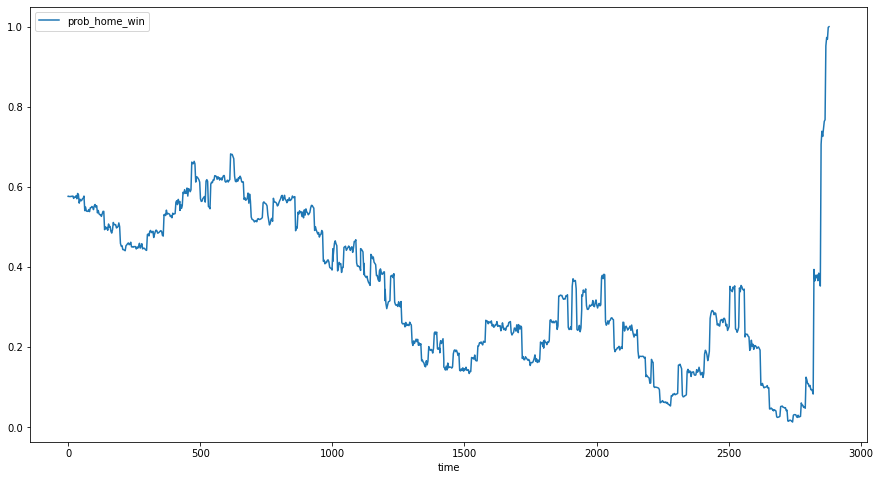

In [16]:
test_df.loc[21501228].sort_values(by='time').plot(x='time', y=['prob_home_win'], figsize=(15,8))

In [22]:
import pickle

pickle.dump(models, '../Models/baseline_logistic.pkl')

TypeError: file must have a 'write' attribute

In [ ]:
with open(outfile, 'wb') as pickle_file:
    cPickle.dump(all, pickle_file)

In [23]:
with open('../Models/baseline_logisitc.pkl', 'wb') as pickle_file:
    pickle.dump(models, pickle_file)